## Pandasを使った実践データ分析

In [4]:
import pandas as pd
import datetime
import numpy as np
import random
import matplotlib.pyplot as plt
import json
import requests
import hashlib
from tqdm import tqdm, tqdm_notebook

%matplotlib inline

In [6]:
# Kaggle上で公開されているFourSquareの行動ログデータを利用
# https://www.kaggle.com/chetanism/foursquare-nyc-and-tokyo-checkin-dataset
# データ数を30,000に絞っています
df = pd.read_csv('data/dataset_TSMC2014_TKY.csv')[['userId', 'venueCategoryId','venueCategory', 'latitude', 'longitude', 'utcTimestamp']].ix[0:30000]

In [7]:
# UTC-JSTに変換する
df['timestamp'] = pd.DatetimeIndex(df.utcTimestamp).tz_localize('UTC').tz_convert('Asia/Tokyo')

In [8]:
df.head(3)

,userId,venueCategoryId,venueCategory,latitude,longitude,utcTimestamp,timestamp
0,1541,4bf58dd8d48988d10c951735,Cosmetics Shop,35.705101,139.619590,Tue Apr 03 18:17:18 +0000 2012,2012-04-04 03:17:18+09:00
1,868,4bf58dd8d48988d1d1941735,Ramen / Noodle House,35.715581,139.800317,Tue Apr 03 18:22:04 +0000 2012,2012-04-04 03:22:04+09:00
2,114,4d954b0ea243a5684a65b473,Convenience Store,35.714542,139.480065,Tue Apr 03 19:12:07 +0000 2012,2012-04-04 04:12:07+09:00


## 基本処理
- カラム名の変更(rename)
- データの取り出し(query)
- 条件にあった行に対しての処理(where)
- 各行に関数を適用する(apply)

In [9]:
# カラム名の変更(rename)
df = df.rename(columns={'userId': 'user_id', 'venueCategoryId': 'venue_category_id', 'venueCategory': 'venue_category', 'latitude': 'lat', 'longitude': 'lng', 
                   'utcTimestamp': 'utc_timestamp'})

- ユーザID (user_id)
- 入店したお店のカテゴリID (venue_category_id)
- 入店したお店のカテゴリ (venue_category)
- お店の緯度・経度情報 (lat, lng)
- 入店時刻 (timestamp)

In [10]:
# データの取り出し(query)
#venue_categoryがAirtportまたはSubwayである行を抽出する
df.query("venue_category in ['Airport', 'Subway']")[['user_id', 'venue_category', 'timestamp']].head(3)

,user_id,venue_category,timestamp
10,589,Airport,2012-04-04 04:59:06+09:00
32,1876,Subway,2012-04-04 05:59:52+09:00
34,499,Subway,2012-04-04 06:04:04+09:00


In [27]:
df.dtypes

user_id                                   int64
venue_category_id                        object
venue_category                           object
lat                                     float64
lng                                     float64
utc_timestamp                            object
timestamp            datetime64[ns, Asia/Tokyo]
dtype: object

In [11]:
# 特定の条件にあった行に対しての処理(where)
df2 = df.copy()

#例: user_idが10以下の行に対して, +10加算する
#条件を満たさない行(other)に対して処理が適用されます
df2['test'] = df2['user_id'].where(cond=lambda x: x >10, other=lambda x: x + 10)

In [12]:
#user_idが10以下の行であるため加算処理が適用される
df2.sort_values('user_id', ascending=True)[['user_id', 'test']].head(1)

,user_id,test
9168,1,11


In [13]:
#user_idが10以上の行であるため加算処理は適用されない
df2.sort_values('user_id', ascending=True)[['user_id', 'test']].tail(1)

,user_id,test
3659,2292,2292


In [15]:
# 関数を適用する(apply)
# 各行にuser_idをハッシュ化する関数を適用する
def _hash(user_id):
    return hashlib.md5(str(user_id).encode('utf-8')).hexdigest()

df2['hash_user_id'] = df2['user_id'].apply(_hash)
df2[['user_id', 'hash_user_id']].head(3)

,user_id,hash_user_id
0,1541,1373b284bc381890049e92d324f56de0
1,868,dd45045f8c68db9f54e70c67048d32e8
2,114,5fd0b37cd7dbbb00f97ba6ce92bf5add


In [36]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()

df3 = df2.ix[0:10].reset_index(drop=True)
# 複数カラムに対して関数を適用する
def gis_to_address(d):
    gis = str(d['lat']) + ', ' + str(d['lng'])
    try:
        return geolocator.reverse(gis).address
    except:
        return None
# 行に対するブロードキャストを指定する(axis=1)
df3['country'] = df3.apply(gis_to_address, axis=1)
df3[['lat', 'lng', 'country']].head(3)

,lat,lng,country
0,35.705101,139.619590,"荻窪タウンセブン, 青梅街道, 善福寺, 杉並区, 東京都, 167-0043, 日本"
1,35.715581,139.800317,"ローソン, 言問通り, 台東区, 東京都, 111-0033, 日本"
2,35.714542,139.480065,"上水本町五丁目, 五日市街道, 花小金井6, 小平市, 東京都, 1890014, 日本"


## Group By
- 最大・最小値である行を抽出(first)
- カラム毎に異なる集計を適用する(agg)
- 標準化(正規化)処理を適用する(transform)

In [38]:
# あるカラム毎に, あるカラム値が最大・最小値である行を抽出(groupby, first)
# 対象のカラム値でsort→ 分割したいカラムを指定 → 分割したいカラムの各最初の行を抽出
# ex. 各ユーザの最終地点(timestampが最後の行)を抽出する
df.sort_values('timestamp', ascending=False).groupby(['user_id'], as_index=False).first()[['user_id', 'venue_category', 'timestamp']].head(5)

,user_id,venue_category,timestamp
0,1,Train Station,2012-04-08 21:24:53+09:00
1,2,Train Station,2012-04-13 20:03:36+09:00
2,3,Smoke Shop,2012-04-13 16:26:35+09:00
3,4,Arcade,2012-04-14 20:24:53+09:00
4,6,Train Station,2012-04-09 06:36:10+09:00


In [39]:
# 1. Round関数を適用し、40分間隔に丸める
df['15min'] = pd.DatetimeIndex(df['timestamp']).round('15min') 

# カラム毎に異なる集計を適用する(agg)
number_of_people = df.groupby(['venue_category', '15min']).agg({'user_id': 'count'}).reset_index()
number_of_people.groupby(['venue_category']).agg({'user_id':  ['mean', 'median']}).reset_index().head(3)

venue_category   user_id       
                            mean median
0              Airport  1.207921      1
1  American Restaurant  1.055556      1
2         Antique Shop  1.000000      1

In [40]:
number_of_people[number_of_people['venue_category'] == 'Subway'].ix[10705:10710]

,venue_category,15min,user_id
10705,Subway,2012-04-04 07:30:00+09:00,8
10706,Subway,2012-04-04 07:45:00+09:00,12
10707,Subway,2012-04-04 08:00:00+09:00,12
10708,Subway,2012-04-04 08:15:00+09:00,12
10709,Subway,2012-04-04 08:30:00+09:00,12
10710,Subway,2012-04-04 08:45:00+09:00,20


In [41]:
# 標準化(正規化)処理を適用する(transform)
number_of_people = df.groupby(['venue_category', '15min']).agg({'user_id': 'count'}).reset_index()

# カテゴリー毎に標準化処理を適用する
zscore = lambda x: (x - x.mean()) / x.std()
number_of_people['standarized_num_people']  = number_of_people.groupby('venue_category').transform(zscore)
t = number_of_people[number_of_people['venue_category'] == 'Subway']
t.columns = ['venue_category', '15min', 'num_people', 'standarized_num_people']

In [42]:
t.ix[10703:10710]

,venue_category,15min,num_people,standarized_num_people
10703,Subway,2012-04-04 07:00:00+09:00,3,-0.501261
10704,Subway,2012-04-04 07:15:00+09:00,4,-0.208489
10705,Subway,2012-04-04 07:30:00+09:00,8,0.962599
10706,Subway,2012-04-04 07:45:00+09:00,12,2.133688
10707,Subway,2012-04-04 08:00:00+09:00,12,2.133688
10708,Subway,2012-04-04 08:15:00+09:00,12,2.133688
10709,Subway,2012-04-04 08:30:00+09:00,12,2.133688
10710,Subway,2012-04-04 08:45:00+09:00,20,4.475866


## 文字 
- 大文字、小文字の置換. 文字数 str.lower(), upper(), len()
- 文字列の置換 str.replace()
- ある文字列を含む行を検索　str.match(), str.contains()

In [45]:
# 大文字、小文字の置換. 文字数 str.lower(), upper(), len()
df['venue_category'].str.lower().head(3)

0           cosmetics shop
1    ramen /  noodle house
2        convenience store
Name: venue_category, dtype: object

In [46]:
df['venue_category'].str.upper().head(3)

0           COSMETICS SHOP
1    RAMEN /  NOODLE HOUSE
2        CONVENIENCE STORE
Name: venue_category, dtype: object

In [47]:
df['venue_category'].str.len().head(3)

0    14
1    21
2    17
Name: venue_category, dtype: int64

In [48]:
# 文字列の置換 str.replace()
df['venue_category'].str.replace('Shop', 'Store').head(3)

0          Cosmetics Store
1    Ramen /  Noodle House
2        Convenience Store
Name: venue_category, dtype: object

In [49]:
# ある文字列を含む行を検索
df[df['venue_category'].str.contains('Store')].head(3)

,user_id,venue_category_id,venue_category,lat,lng,utc_timestamp,timestamp,15min
2,114,4d954b0ea243a5684a65b473,Convenience Store,35.714542,139.480065,Tue Apr 03 19:12:07 +0000 2012,2012-04-04 04:12:07+09:00,2012-04-04 04:15:00+09:00
5,1541,4bf58dd8d48988d1f8941735,Furniture / Home Store,35.705074,139.619502,Tue Apr 03 19:20:09 +0000 2012,2012-04-04 04:20:09+09:00,2012-04-04 04:15:00+09:00
6,1541,4d954b0ea243a5684a65b473,Convenience Store,35.706277,139.617782,Tue Apr 03 19:21:00 +0000 2012,2012-04-04 04:21:00+09:00,2012-04-04 04:15:00+09:00


## スタイル
- 指定した条件に合致したセルに色をつける(style.applymap)
- 最大値・最小値に色をつける(style.highlight_max)
- 値に応じたbar　chartを表示する(style.bar)

In [50]:
number_of_people['date'] = number_of_people['15min'].dt.date
number_of_people2 = number_of_people.groupby(['venue_category']).agg({'user_id':  'std'}).reset_index().fillna(0).ix[0:5]

In [51]:
def color_negative_red(val):
    color = 'red' if val <= 0 else 'black'
    return 'color: %s' % color

# 指定した条件に合致したセルに色をつける(style.applymap)
number_of_people3 = number_of_people2.set_index('venue_category')
number_of_people3.style.applymap(color_negative_red)

In [52]:
# 最大値のセルに色をつける
number_of_people3.style.highlight_max(axis=0)

In [53]:
# 最小値のセルに色をつける
number_of_people3.style.highlight_min(axis=0)

In [54]:
# 値に応じたbar　chartを表示する(style.bar)
number_of_people3.style.bar(subset=['user_id'], color='#d65f5f')

## 時系列データ
- 時間の丸め処理(round)
- 変化量(diff)
- 変化量_%(pct_change)
- EMA(rolling)


### 15分間隔ごとの来客人数を集計する

In [55]:
# 1. Round関数を適用し、15分間隔に丸める
df['15min'] = pd.DatetimeIndex(df['timestamp']).round('15min')  
# 2. 15分間隔に丸めた時刻カラムでグルーピングし、カウント関数を適用する
count_people_by_15min = df.groupby(by='15min').agg({'user_id': 'count'})
count_people_by_15min.head(3)

,user_id
15min,
2012-04-04 03:15:00+09:00,2
2012-04-04 04:15:00+09:00,5
2012-04-04 04:30:00+09:00,1


In [56]:
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour

In [57]:
df[['user_id', 'venue_category', 'timestamp','date' ,'hour', '15min']].head(3)

,user_id,venue_category,timestamp,date,hour,15min
0,1541,Cosmetics Shop,2012-04-04 03:17:18+09:00,2012-04-04,3,2012-04-04 03:15:00+09:00
1,868,Ramen / Noodle House,2012-04-04 03:22:04+09:00,2012-04-04,3,2012-04-04 03:15:00+09:00
2,114,Convenience Store,2012-04-04 04:12:07+09:00,2012-04-04,4,2012-04-04 04:15:00+09:00


### 移動平均や変化量を算出する 

In [58]:
# MultindexをColumnに変換する
count_people_by_15min = count_people_by_15min.reset_index()

In [59]:
count_people_by_15min.columns = ['15min', 'num_of_people']

In [60]:
# 変化量はdiff関数を適用する
count_people_by_15min['change'] = count_people_by_15min['num_of_people'].diff()
# 変化量(%)はpct_change関数を利用する
count_people_by_15min['pct_change'] = count_people_by_15min['num_of_people'].pct_change()
# 単純移動平均(EMA)はrolling_mean関数を利用する
count_people_by_15min['rolling_mean'] = count_people_by_15min['num_of_people'].rolling(window=3, center=False).mean()

In [61]:
count_people_by_15min.head(5)

,15min,num_of_people,change,pct_change,rolling_mean
0,2012-04-04 03:15:00+09:00,2,NaN,NaN,NaN
1,2012-04-04 04:15:00+09:00,5,3.0,1.5,NaN
2,2012-04-04 04:30:00+09:00,1,-4.0,-0.8,2.666667
3,2012-04-04 04:45:00+09:00,2,1.0,1.0,2.666667
4,2012-04-04 05:00:00+09:00,2,0.0,0.0,1.666667


### 3. カテゴリ別に上記指標を算出する

In [63]:
count_people_div_15min_venue_category = df.groupby(['venue_category', '15min']).agg({'user_id': 'count'}).reset_index()

count_people_div_15min_venue_category['change'] = count_people_div_15min_venue_category.groupby('venue_category')['user_id'].diff()
count_people_div_15min_venue_category['pct_change'] = count_people_div_15min_venue_category.groupby('venue_category')['user_id'].pct_change()

_rolling_mean = count_people_div_15min_venue_category.groupby('venue_category')['user_id'].rolling(window=3, center=False).mean()
count_people_div_15min_venue_category['rolling_mean'] = _rolling_mean.reset_index(level=0, drop=True)

In [64]:
count_people_div_15min_venue_category[count_people_div_15min_venue_category['venue_category'] == 'Subway'].head(5)

,venue_category,15min,user_id,change,pct_change,rolling_mean
10701,Subway,2012-04-04 06:00:00+09:00,2,NaN,NaN,NaN
10702,Subway,2012-04-04 06:45:00+09:00,2,0.0,0.000000,NaN
10703,Subway,2012-04-04 07:00:00+09:00,3,1.0,0.500000,2.333333
10704,Subway,2012-04-04 07:15:00+09:00,4,1.0,0.333333,3.000000
10705,Subway,2012-04-04 07:30:00+09:00,8,4.0,1.000000,5.000000


### 4. 可視化 

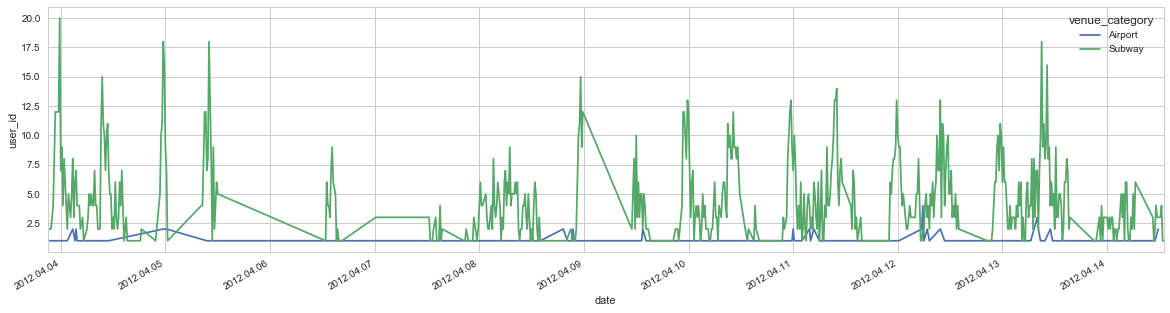

In [69]:
import seaborn as sns
import matplotlib.dates as mdates

# Subset
df_ts_plot = count_people_div_15min_venue_category.query("venue_category in ['Airport', 'Subway']").reset_index(drop=True)

# Setting for plotting
df_ts_plot['dummy'] = 1.0
df_ts_plot['date'] = df_ts_plot['15min'].apply(mdates.date2num)

fig, ax = plt.subplots(figsize=(20, 5))
sns.set_style('whitegrid')

# Plot
sns.tsplot(data=df_ts_plot, time='date', unit='dummy', condition='venue_category', value='user_id', ax=ax)

# assign locator and formatter for the xaxis ticks.
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y.%m.%d'))

# put the labels at 45deg since they tend to be too long
fig.autofmt_xdate()

### おすすめライブラリ
- 処理・経過情報をタイムバーで表示してくれるライブラリ(tqdm)
- DataFrameをMarkdownで出力するライブラリ(pytablewriter)

In [115]:
# 処理・経過情報をタイムバーで表示してくれるライブラリ(tqdm)
_df = pd.DataFrame(np.random.randint(0, 100, (100000, 6)))

In [109]:
# pandasに適用する
# https://pypi.python.org/pypi/tqdm#pandas-integration
# Now you can use `progress_apply` instead of `apply`
# and `progress_map` instead of `map`
tqdm_notebook().pandas()

In [114]:
def _test(t):
    sleep(1.0)
    return t**2
# _df.progress_apply(_test)

In [381]:
import pytablewriter

writer = pytablewriter.MarkdownTableWriter()
writer.from_dataframe(count_people_div_15min_venue_category.head(5))
writer.write_table()

venue_category|         15min          |user_id|change|pct_change|rolling_mean
--------------|------------------------|------:|-----:|---------:|-----------:
Airport       |2012-04-04T05:00:00+0900|      1|   NaN|       NaN|         NaN
Airport       |2012-04-04T07:00:00+0900|      1|     0|         0|         NaN
Airport       |2012-04-04T08:15:00+0900|      1|     0|         0|        1.00
Airport       |2012-04-04T10:30:00+0900|      1|     0|         0|        1.00
Airport       |2012-04-04T11:45:00+0900|      2|     1|         1|        1.33



category|      15_interval       |user_id|change|pct_change|rolling_mean
--------|------------------------|------:|-----:|---------:|-----------:
Airport |2012-04-04T05:00:00+0900|      1|   NaN|       NaN|         NaN
Airport |2012-04-04T07:00:00+0900|      1|     0|         0|         NaN
Airport |2012-04-04T08:15:00+0900|      1|     0|         0|        1.00
Airport |2012-04-04T10:30:00+0900|      1|     0|         0|        1.00
Airport |2012-04-04T11:45:00+0900|      2|     1|         1|        1.33